# Welcome to chessGPT

In [1]:
import chess
import math
import torch
import pprint
import torch.nn as nn
import chess.pgn as pgn


pp = pprint.PrettyPrinter(indent=4)

## Vocabulary
bidirectional dict that will be used for board encoding / decoding

In [2]:
board_vocab = [ ' ', '/', '0', '1', 'u', 'U', 'v', 'V', 'w', 'W', 'x', 'X', '#', 'K', 'Q', 'R', 'B', 'N', 'P', 'k', 'q', 'r', 'b', 'n', 'p']
vocab_map = {}
board_stoi = {ch: i for i, ch in enumerate(board_vocab)}
board_itos = {i: ch for i, ch in enumerate(board_vocab)}
vocab_map.update(board_stoi)
vocab_map.update(board_itos)
pp.pprint(vocab_map)


{   0: ' ',
    1: '/',
    2: '0',
    3: '1',
    4: 'u',
    5: 'U',
    6: 'v',
    7: 'V',
    8: 'w',
    9: 'W',
    10: 'x',
    11: 'X',
    12: '#',
    13: 'K',
    14: 'Q',
    15: 'R',
    16: 'B',
    17: 'N',
    18: 'P',
    19: 'k',
    20: 'q',
    21: 'r',
    22: 'b',
    23: 'n',
    24: 'p',
    ' ': 0,
    '#': 12,
    '/': 1,
    '0': 2,
    '1': 3,
    'B': 16,
    'K': 13,
    'N': 17,
    'P': 18,
    'Q': 14,
    'R': 15,
    'U': 5,
    'V': 7,
    'W': 9,
    'X': 11,
    'b': 22,
    'k': 19,
    'n': 23,
    'p': 24,
    'q': 20,
    'r': 21,
    'u': 4,
    'v': 6,
    'w': 8,
    'x': 10}


## Board encoding
We encode the board in such a way that we garantee the output vector will have a constant length 

In [3]:
class BoardEncoder:

    def __init__(self, vocab_map) -> None:
        self.vocab_map = vocab_map

    def get_pieces(self, board):
        """We will keep the same encoding as in the FEN notation.
        But we will encode empty squares with a # character.
        """
        fen = board.fen()
        pieces = fen.split()[0]
        for piece in pieces:
            if piece.isdecimal():
                pieces = pieces.replace(piece, '#' * int(piece))
        return pieces

    def get_turn(self, board):
        """
        0: black
        1: white
        """
        return "0" if board.turn == chess.BLACK else "1"

    def get_castling_rights(self, board):
        """
        u: no castling rights for black
        U: no castling rights for white
        v: queenside castling rights for black
        V: queenside castling rights for white
        w: kingside castling rights for black
        W: kingside castling rights for white
        x: both castling rights for black
        X: both castling rights for white
        """

        castling_rights = ["U", "u"]

        if board.has_queenside_castling_rights(chess.WHITE) and board.has_kingside_castling_rights(chess.WHITE):
            castling_rights[0] = "X"
        elif board.has_queenside_castling_rights(chess.WHITE):
            castling_rights[0] = "V"
        elif board.has_kingside_castling_rights(chess.WHITE):
            castling_rights[0] = "W"

        if board.has_queenside_castling_rights(chess.BLACK) and board.has_kingside_castling_rights(chess.BLACK):
            castling_rights[1] = "x"
        elif board.has_queenside_castling_rights(chess.BLACK):
            castling_rights[1] = "v"
        elif board.has_kingside_castling_rights(chess.BLACK):
            castling_rights[1] = "w"

        return "".join(castling_rights)

    def encode_str(self, board):
        return self.get_pieces(board) + " " + self.get_turn(board) + " " + self.get_castling_rights(board)
    
    def encode_int(self, board):
        return [self.vocab_map[ch] for ch in self.encode_str(board)]
    
    def to_tensor(self, board):
        return torch.tensor(self.encode_int(board), dtype=torch.long)

In [4]:
# Encode
board = chess.Board('r1bqkb1r/pppp1Qpp/2n2n2/4p3/2B1P3/8/PPPP1PPP/RNB1K1NR b KQkq - 0 4')
print(board.fen())
board_encoder = BoardEncoder(vocab_map)
encoded_board_str = board_encoder.encode_str(board)
print(encoded_board_str)
encoded_board_int = board_encoder.encode_int(board)
print(encoded_board_int)

r1bqkb1r/pppp1Qpp/2n2n2/4p3/2B1P3/8/PPPP1PPP/RNB1K1NR b KQkq - 0 4
r#bqkb#r/pppp#Qpp/##n##n##/####p###/##B#P###/########/PPPP#PPP/RNB#K#NR 0 Xx
[21, 12, 22, 20, 19, 22, 12, 21, 1, 24, 24, 24, 24, 12, 14, 24, 24, 1, 12, 12, 23, 12, 12, 23, 12, 12, 1, 12, 12, 12, 12, 24, 12, 12, 12, 1, 12, 12, 16, 12, 18, 12, 12, 12, 1, 12, 12, 12, 12, 12, 12, 12, 12, 1, 18, 18, 18, 18, 12, 18, 18, 18, 1, 15, 17, 16, 12, 13, 12, 17, 15, 0, 2, 0, 11, 10]


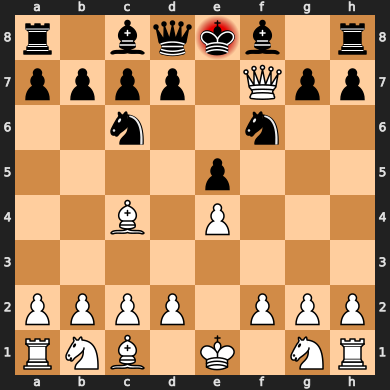

In [5]:
board

## Board decoding

In [6]:
class BoardDecoder:

    def __init__(self, vocab_map) -> None:
        self.vocab_map = vocab_map
        
    def decode_str(self, board):
        return "".join(self.vocab_map[int(v)] for v in board)
    
    def get_pieces(self, board):
        """Run length encoding of every # character.
        """  
        fen = self.decode_str(board)
        pieces = fen.split()[0]
        out = ""
        c = 0
        for piece in pieces:
            if piece == "#":
                c += 1
            elif c:
                out += str(c)
                out += piece
                c = 0
            else:
                out += piece
        if c:
            out += str(c)
        return out 
    
    def get_turn(self, board):
        """
        b: black
        w: white
        """
        fen = self.decode_str(board)
        turn = fen.split()[1][0]
        return "b" if turn == "0" else "w"
        
    def get_castling_rights(self, board):
        """
        -: no castling rights either side
        q: queenside castling rights for black
        Q: queenside castling rights for white
        k: kingside castling rights for black
        K: kingside castling rights for white
        kq: both castling rights for black
        KQ: both castling rights for white
        """
        fen = self.decode_str(board)
        castling_rights = fen.split()[2]
        out = ""
        if castling_rights[0] == "X":
            out += "KQ"
        elif castling_rights[0] == "V":
            out += "Q"
        elif castling_rights[0] == "W":
            out += "K"
        
        if castling_rights[1] == "x":
            out += "kq"
        elif castling_rights[1] == "v":
            out += "q"
        elif castling_rights[1] == "w":
            out += "k"

        if castling_rights[0] == "U" and castling_rights[1] == "u":
            out = "-"
            
        return out
        
    def to_fen(self, board):
        return self.get_pieces(board) + " " + self.get_turn(board) + " " + self.get_castling_rights(board)
    
    def to_board(self, board):
        return chess.Board(self.to_fen(board))

In [7]:
# Decode 
board_decoder = BoardDecoder(vocab_map)
decoded_board_str = board_decoder.decode_str(encoded_board_int)
print(decoded_board_str)
decoded_fen = board_decoder.to_fen(encoded_board_int)
print(decoded_fen)
decoded_board = board_decoder.to_board(encoded_board_int)

r#bqkb#r/pppp#Qpp/##n##n##/####p###/##B#P###/########/PPPP#PPP/RNB#K#NR 0 Xx
r1bqkb1r/pppp1Qpp/2n2n2/4p3/2B1P3/8/PPPP1PPP/RNB1K1NR b KQkq


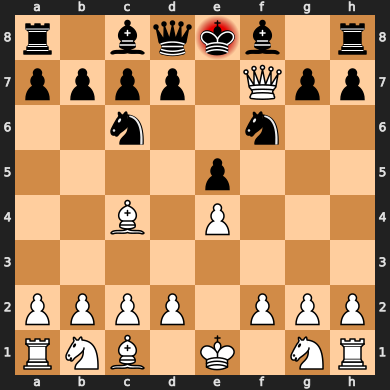

In [8]:
decoded_board

## Read PGN game

In [9]:
def read_pgn(pgn_file, n_moves=None):
    i = 0
    if n_moves is None:
        n_moves = float("inf")

    def next_game(games):
        game = pgn.read_game(games)
        if game is None:
            return False, None, None
        board = game.board()
        game_moves = iter(game.mainline_moves())
        return True, board, game_moves
    
    with open(pgn_file) as games:
        flag, board, game_moves = next_game(games)
        while i < n_moves:
            if not flag:
                break
            move = next(game_moves, None)
            if move:
                board.push(move)
                yield board
                i += 1
            else:
                flag, board, game_moves = next_game(games)
            

for board in read_pgn("../data/master_games.pgn", n_moves=3):
    print(board)
    print()

r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . P . . . .
. . . . . . . .
P P P . P P P P
R N B Q K B N R

r n b q k b . r
p p p p p p p p
. . . . . n . .
. . . . . . . .
. . . P . . . .
. . . . . . . .
P P P . P P P P
R N B Q K B N R

r n b q k b . r
p p p p p p p p
. . . . . n . .
. . . . . . . .
. . P P . . . .
. . . . . . . .
P P . . P P P P
R N B Q K B N R



In [10]:
import random
from torch.utils.data.dataset import Dataset
from torch.utils.data.dataloader import DataLoader


class PGNDataset(Dataset):
    
    def __init__(self, pgn_file, vocab_map, player_name=None):
        super().__init__()
        self.pgn_file = pgn_file
        self.player_name = player_name
        self.board_encoder = BoardEncoder(vocab_map)
        self.data = self.build_dataset(pgn_file, player_name)

    @staticmethod
    def get_player_by_name(game, player_name):
        if player_name is None:
            return random.choice([chess.WHITE, chess.BLACK])
        return chess.WHITE if game.headers["White"] == player_name else chess.BLACK
    
    def extract_game(self, game, player_name):
        src_data = []
        tgt_data = []
        board = game.board()
        player = PGNDataset.get_player_by_name(game, player_name)
        for i, move in enumerate(game.mainline_moves()):
            if i == 0 and player == chess.BLACK:
                board.push(move)
            encoded = self.board_encoder.to_tensor(board)
            if board.turn == player:
                src_data.append(encoded)
            else:
                tgt_data.append(encoded)
            board.push(move)

        if len(src_data) > len(tgt_data):
            src_data = src_data[:-1]

        return list(zip(src_data, tgt_data))
    
    def build_dataset(self, pgn_file, player_name):
        dataset = []
        games = open(pgn_file)
        while True:
            game = pgn.read_game(games)
            if game is None:
                break
            dataset += self.extract_game(game, player_name)
        return dataset
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        return self.data[idx]

In [11]:
batch_size = 4

dataset = PGNDataset(
    pgn_file="../data/master_games.pgn",
    vocab_map=vocab_map,
    player_name="Carlsen, Magnus"
)
dataloader = DataLoader(
    dataset, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=4
)

In [12]:
board_decoder = BoardDecoder(vocab_map)
src_data, tgt_data = next(iter(dataloader))
print(src_data.shape)
print(tgt_data.shape)

for i in range(batch_size):
    src = src_data[i, :]
    tgt = tgt_data[i, :]

    src_board = board_decoder.to_board(src)
    tgt_board = board_decoder.to_board(tgt)
    
    print(src_board)
    print()
    print(tgt_board)
    print()


torch.Size([4, 76])
torch.Size([4, 76])
r n b q k . . r
p p . . p p b p
. . p . . . p .
. B . . . . . .
. . . P P . . .
. . P . . . . .
P . . . . P P P
R . B Q K . N R

r n b q k . . r
p p . . p p b p
. . p . . . p .
. . . . . . . .
B . . P P . . .
. . P . . . . .
P . . . . P P P
R . B Q K . N R

. . r . r b k .
p p . . . . p p
. n . . . p q .
. R . p . . . .
. . . . . B . P
. . P R P . . .
P . . N . P P .
. Q . . . . K .

. . r . r b k .
p p . . . . p p
. n . . . p q .
R . . p . . . .
. . . . . B . P
. . P R P . . .
P . . N . P P .
. Q . . . . K .

. . . R . Q . .
. p . . . p p k
. . p . p . . .
. q . . . . . p
. P . . r . . P
. . . . . . P .
. . . . . P K .
. . . . . . . .

. . . R . . . .
. p . . . Q p k
. . p . p . . .
. q . . . . . p
. P . . r . . P
. . . . . . P .
. . . . . P K .
. . . . . . . .

. r . . . . k .
. . p . . . p .
. . . p p n . p
. . . . . . . .
. . N p P . . .
. . P n P . . P
. . . N . . P .
R . . . . . K .

. r . . . . k .
. . p . . . p .
. . . p p n . p
. . . . .

## Model design

In [13]:
class MultiHeadAttention(nn.Module):
    """
    https://towardsdatascience.com/build-your-own-transformer-from-scratch-using-pytorch-84c850470dcb
    """
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads
        
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)
        
    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, -1e9)
        attn_probs = torch.softmax(attn_scores, dim=-1)
        output = torch.matmul(attn_probs, V)
        return output
        
    def split_heads(self, x):
        batch_size, seq_length, d_model = x.size()
        return x.view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1, 2)
        
    def combine_heads(self, x):
        batch_size, _, seq_length, d_k = x.size()
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)
        
    def forward(self, Q, K, V, mask=None):
        Q = self.split_heads(self.W_q(Q))
        K = self.split_heads(self.W_k(K))
        V = self.split_heads(self.W_v(V))
        
        attn_output = self.scaled_dot_product_attention(Q, K, V, mask)
        output = self.W_o(self.combine_heads(attn_output))
        return output

In [14]:
class PositionWiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(PositionWiseFeedForward, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))

In [15]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length):
        super(PositionalEncoding, self).__init__()
        
        pe = torch.zeros(max_seq_length, d_model)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        self.register_buffer('pe', pe.unsqueeze(0))
        
    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

In [16]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, mask):
        attn_output = self.self_attn(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x

In [17]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.cross_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, enc_output, src_mask, tgt_mask):
        attn_output = self.self_attn(x, x, x, tgt_mask)
        x = self.norm1(x + self.dropout(attn_output))
        attn_output = self.cross_attn(x, enc_output, enc_output, src_mask)
        x = self.norm2(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm3(x + self.dropout(ff_output))
        return x

In [18]:
class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout):
        super(Transformer, self).__init__()
        self.encoder_embedding = nn.Embedding(src_vocab_size, d_model)
        self.decoder_embedding = nn.Embedding(tgt_vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_seq_length)

        self.encoder_layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.decoder_layers = nn.ModuleList([DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])

        self.fc = nn.Linear(d_model, tgt_vocab_size)
        
        self.dropout = nn.Dropout(dropout)

    def generate_mask(self, src, tgt):
        src_mask = (src != 0).unsqueeze(1).unsqueeze(2)
        tgt_mask = (tgt != 0).unsqueeze(1).unsqueeze(3)
        seq_length = tgt.size(1)
        nopeak_mask = (1 - torch.triu(torch.ones(1, seq_length, seq_length), diagonal=1)).bool()
        tgt_mask = tgt_mask & nopeak_mask
        return src_mask, tgt_mask

    def forward(self, src, tgt, causal=False):
        src_mask, tgt_mask = self.generate_mask(src, tgt) if causal else None, None
        src_embedded = self.dropout(self.positional_encoding(self.encoder_embedding(src)))
        tgt_embedded = self.dropout(self.positional_encoding(self.decoder_embedding(tgt)))

        enc_output = src_embedded
        for enc_layer in self.encoder_layers:
            enc_output = enc_layer(enc_output, src_mask)

        dec_output = tgt_embedded
        for dec_layer in self.decoder_layers:
            dec_output = dec_layer(dec_output, enc_output, src_mask, tgt_mask)

        output = self.fc(dec_output)
        return output

## Model training

In [19]:
src_vocab_size = len(board_vocab) # 25
tgt_vocab_size = len(board_vocab) # 25
d_model = 8
num_heads = 8
num_layers = 4
d_ff = 2048
max_seq_length = 76
dropout = 0.1

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Device used: {device}")

transformer = Transformer(src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout)

# Generate random sample data
# src_data = torch.randint(1, src_vocab_size, (64, max_seq_length))  # (batch_size, seq_length)
# tgt_data = torch.randint(1, tgt_vocab_size, (64, max_seq_length))  # (batch_size, seq_length)

Device used: cuda:0


In [20]:
import wandb

wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


True

In [26]:
config = \
{
    "learning_rate": 0.0001,
    "betas": (0.9, 0.98),
    "epsilon": 1e-9,
    "epochs": 2000,
    "batch_size": 64,
    "log_interval": 10,
    "player": "Carlsen, Magnus",
    "model_path": "../checkpoints/magnus.pt"
}

wandb.init(project="chessGPT")
wandb.config = config
wandb.watch(transformer)

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▇▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
epoch,99
loss,9.86043


[]

In [27]:
dataset = PGNDataset(
    pgn_file="../data/master_games.pgn",
    vocab_map=vocab_map,
    player_name="Carlsen, Magnus"
)

dataloader = DataLoader(
    dataset, 
    batch_size=config["batch_size"], 
    shuffle=True, 
    num_workers=4
)

In [ ]:
import torch.optim as optim
from tqdm import tqdm


criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(
    transformer.parameters(), 
    lr=config["learning_rate"], 
    betas=config["betas"], 
    eps=config["epsilon"]
)

transformer.train().to(device)
min_running_loss = float("inf")

for epoch in tqdm(range(config["epochs"])):
    running_loss = 0.
    for src_data, tgt_data in dataloader:
        optimizer.zero_grad()
        output = transformer(src_data.to(device), tgt_data.to(device))
        loss = criterion(output.contiguous().view(-1, tgt_vocab_size), tgt_data.contiguous().view(-1).to(device))
        # print(output.contiguous().view(-1, max_seq_length, tgt_vocab_size).shape)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    if running_loss < min_running_loss:
        print(f"loss decreases: {min_running_loss:0.2f} -> {running_loss:0.2f}")
        min_running_loss = running_loss
        torch.save(transformer.state_dict(), config["model_path"])

    wandb.log({
        "loss": running_loss,
        "epoch": epoch,
        })

## Inference

In [33]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Device used: {device}")

transformer = Transformer(src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout)
transformer.load_state_dict(torch.load(config["model_path"]))
transformer.eval().to(device)

Device used: cuda:0


Transformer(
  (encoder_embedding): Embedding(25, 8)
  (decoder_embedding): Embedding(25, 8)
  (positional_encoding): PositionalEncoding()
  (encoder_layers): ModuleList(
    (0-3): 4 x EncoderLayer(
      (self_attn): MultiHeadAttention(
        (W_q): Linear(in_features=8, out_features=8, bias=True)
        (W_k): Linear(in_features=8, out_features=8, bias=True)
        (W_v): Linear(in_features=8, out_features=8, bias=True)
        (W_o): Linear(in_features=8, out_features=8, bias=True)
      )
      (feed_forward): PositionWiseFeedForward(
        (fc1): Linear(in_features=8, out_features=2048, bias=True)
        (fc2): Linear(in_features=2048, out_features=8, bias=True)
        (relu): ReLU()
      )
      (norm1): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (decoder_layers): ModuleList(
    (0-3): 4 x DecoderLayer(
      (self_attn): MultiHeadAtten

In [50]:
board_decoder = BoardDecoder(vocab_map)
board_encoder = BoardEncoder(vocab_map)

src_data, tgt_data = next(iter(dataloader))
out_data = transformer(src_data.to(device), tgt_data.to(device)).cpu()

print(src_data.shape)
print(tgt_data.shape)
print(out_data.shape)

for i in range(batch_size):
    src = src_data[i, :]
    tgt = tgt_data[i, :]
    out = torch.max(out_data[i, :], dim=1).values

    src_str = board_decoder.decode_str(src)
    tgt_str = board_decoder.decode_str(tgt)
    out_str = board_decoder.decode_str(out)

    print(src_str)
    print(tgt_str)
    print(out_str)

    # TODO: compute loss for every possible move
    # src_board = board_decoder.to_board(src)
    # losses = {}
    # for move in src_board.legal_moves:
    #     src_board.push(move)
    #     tmp = board_encoder.to_tensor(src_board)
    #     losses[move] = criterion(out.contiguous(), tmp.contiguous())
    #     src_board.pop()


Exception ignored in: <function tqdm.__del__ at 0x7ffabc6a6950>
Traceback (most recent call last):
  File "/home/vador/git/chessGPT/venv/lib/python3.10/site-packages/tqdm/std.py", line 1145, in __del__
    self.close()
  File "/home/vador/git/chessGPT/venv/lib/python3.10/site-packages/tqdm/notebook.py", line 283, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm_notebook' object has no attribute 'disp'


torch.Size([64, 76])
torch.Size([64, 76])
torch.Size([64, 76, 25])
######Q#/########/########/#k######/#p######/####q#K#/########/######## 1 Uu
######Q#/########/########/#k######/#p######/####q###/######K#/######## 0 Uu
QQQQQQQQRQQQQQQQQBQQQQQQQQBQQQQQQQQBQBQQQQQQBQQQQBQQQBQQQQQQQQBQQQQQQQQQP#QQ


RuntimeError: Expected floating point type for target with class probabilities, got Long

We can see that the model outputs bullshit, actually we could impose some modification:
- the "/" and " " characters always remain
- the "1" always become "0" and vice versa
- the output is a slight modification of the input => out = in + sparse_delta

Whatever the model outputs, it is difficult to hope that it will output a board lying in src.legal_moves

In [24]:
# TODO:
# lightning modules

In [25]:
# TODO: 
# at inference time,
# compute the loss between output_data and every possible move (tgt_data)
# and take the min loss (or use some proba distribution)
# the only difference is that backprop is off 